# Homework 4

In [2]:
#2.1
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
(train_ds, test_ds), ds_info = tfds.load('mnist', split =['train', 'test'], as_supervised = True, with_info = True)

c:\Users\Moritz\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def prepare_mnist(mnist):
    mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32), target))
    mnist = mnist.map(lambda img, target: (tf.reshape(img, (-1,)), target))
    mnist = mnist.map(lambda img, target: ((img/128.)-1., target))
    #mnist = mnist.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
    mnist = mnist.shuffle(1000)
    #mnist = mnist.batch(64)
    mnist = mnist.prefetch(20)
    return mnist

train_ds = train_ds.apply(prepare_mnist)
test_ds = test_ds.apply(prepare_mnist)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [46]:
def preprocessing_subtract(mnist):
    zipped_mnist = tf.data.Dataset.zip((mnist, mnist))
    zipped_mnist = zipped_mnist.map(lambda x1, x2: (x1[0], x2[0], x1[1]-x2[1]+9))
    zipped_mnist = zipped_mnist.map(lambda x1, x2, target: (x1, x2, tf.one_hot(target, depth=20)))
    zipped_mnist = zipped_mnist.batch(32)
    return zipped_mnist

def preprocessing_greater(mnist):
    zipped_mnist = tf.data.Dataset.zip((mnist, mnist))
    zipped_mnist = zipped_mnist.map(lambda x1, x2: (x1[0], x2[0], x1[1]+x2[1]>=5))
    zipped_mnist = zipped_mnist.map(lambda x1, x2, t: (x1,x2, tf.cast(t, tf.int32)))
    zipped_mnist = zipped_mnist.batch(32)
    return zipped_mnist

train_dataset_subtract = train_ds.apply(preprocessing_subtract)
test_dataset_subtract = test_ds.apply(preprocessing_subtract)

train_dataset_greater = train_ds.apply(preprocessing_greater)
test_dataset_greater = test_ds.apply(preprocessing_greater)

print(train_dataset_greater.take(1))

'''
for element1, element2, label in train_dataset_greater.take(1):
    img1 = np.asarray(element1).reshape((28,28))
    img2 = np.asarray(element2).reshape((28,28))
    plt.imshow(img1)
    plt.show()
    plt.imshow(img2)
    plt.show()
    print(np.asarray(label))
'''


<TakeDataset element_spec=(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None, 784), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


'\nfor element1, element2, label in train_dataset_greater.take(1):\n    img1 = np.asarray(element1).reshape((28,28))\n    img2 = np.asarray(element2).reshape((28,28))\n    plt.imshow(img1)\n    plt.show()\n    plt.imshow(img2)\n    plt.show()\n    print(np.asarray(label))\n'

## 3

In [47]:
class TwinModel(tf.keras.Model):
    def __init__(self):
        super(TwinModel, self).__init__()
        self.optimizer = tf.keras.optimizers.Adam()
        self.loss_function = tf.keras.losses.BinaryCrossentropy()

        self.dense1 = tf.keras.layers.Dense(128, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(64, activation=tf.nn.relu)
        self.out = tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)

    @tf.function
    def call(self, images):
        img1, img2 = images
        
        img1_x = self.dense1(img1)
        img1_x = self.dense2(img1_x)
        
        img2_x = self.dense1(img2)
        img2_x = self.dense2(img2_x)
        
        combined_x = tf.concat([img1_x, img2_x ], axis=1)
        
        return self.out(combined_x)


In [48]:
class TwinModelSubtract(tf.keras.Model):
    def __init__(self):
        super(TwinModelSubtract, self).__init__()
        self.optimizer = tf.keras.optimizers.Adam()
        self.loss_function = tf.keras.losses.BinaryCrossentropy()

        self.dense1 = tf.keras.layers.Dense(128, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(64, activation=tf.nn.relu)
        self.out = tf.keras.layers.Dense(20, activation=tf.nn.softmax)

    @tf.function
    def call(self, images):
        img1, img2 = images
        
        img1_x = self.dense1(img1)
        img1_x = self.dense2(img1_x)
        
        img2_x = self.dense1(img2)
        img2_x = self.dense2(img2_x)
        
        combined_x = tf.concat([img1_x, img2_x ], axis=1)
        
        return self.out(combined_x)


In [61]:
def train_step(model, data):
    img1, img2, label = data
    
    with tf.GradientTape() as tape:
        output = model((img1, img2))
        loss = model.loss_function(label, output)
        gradients = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def test_model(model, test_data, operation):
    test_accuracy_aggregator = []

    for (img1, img2, target) in test_data:
        prediction = model((img1, img2), training=False)
        #print(np.reshape(np.around(prediction),(-1)).astype("int"))
        #print(np.around(prediction))
        #print(np.asarray(target))
        #sample_test_accuracy = np.asarray(target) == np.reshape(np.around(prediction),(-1))
        #print(np.argmax(target, axis=1))
        #print(np.argmax(prediction, axis=1))
        if operation == "subtract":
            sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        elif operation == "greater":
            sample_test_accuracy = np.asarray(target) == np.reshape(np.around(prediction),(-1))
        #print(sample_test_accuracy)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

    test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

    return test_accuracy

def train_loop(model, train_data, test_data, operation="lol", epochs=10):
    for epoch in range(1,epochs+1):
        epoch_loss = []
        for input in train_data:
            epoch_loss.append(train_step(model, input))
        test_accuracy = test_model(model, test_data, operation)
        print("Epoch: ", epoch, "Loss: ", np.asarray(tf.reduce_mean(epoch_loss)), "Accuracy: ", np.asarray(test_accuracy))


In [62]:
twinmodel_greater = TwinModel()
train_loop(twinmodel_greater, train_dataset_greater, test_dataset_greater, "greater", 5)

Epoch:  1 Loss:  0.19634125 Accuracy:  0.9468849840255591
Epoch:  2 Loss:  0.12687847 Accuracy:  0.9626597444089456
Epoch:  3 Loss:  0.11635615 Accuracy:  0.9575678913738019
Epoch:  4 Loss:  0.10455334 Accuracy:  0.9665535143769968


In [64]:
twinmodel_subtract = TwinModelSubtract()
train_loop(twinmodel_subtract, train_dataset_subtract, test_dataset_subtract, "subtract", 20)

Epoch:  1 Loss:  0.14998612 Accuracy:  0.3442492012779553
Epoch:  2 Loss:  0.12451054 Accuracy:  0.41813099041533547
Epoch:  3 Loss:  0.11491057 Accuracy:  0.4858226837060703
Epoch:  4 Loss:  0.10871638 Accuracy:  0.4910143769968051
Epoch:  5 Loss:  0.10436789 Accuracy:  0.5316493610223643
Epoch:  6 Loss:  0.10027262 Accuracy:  0.5786741214057508
Epoch:  7 Loss:  0.09699908 Accuracy:  0.5972444089456869
Epoch:  8 Loss:  0.09437334 Accuracy:  0.6116214057507987
Epoch:  9 Loss:  0.09195924 Accuracy:  0.6508586261980831
Epoch:  10 Loss:  0.08979086 Accuracy:  0.6649361022364217
Epoch:  11 Loss:  0.08725786 Accuracy:  0.6882987220447284
Epoch:  12 Loss:  0.08590402 Accuracy:  0.6847044728434505
Epoch:  13 Loss:  0.084022306 Accuracy:  0.6844049520766773
Epoch:  14 Loss:  0.08255156 Accuracy:  0.7042731629392971
Epoch:  15 Loss:  0.08118219 Accuracy:  0.6957867412140575
Epoch:  16 Loss:  0.07975053 Accuracy:  0.7515974440894568
Epoch:  17 Loss:  0.07895512 Accuracy:  0.7304313099041534
Epoc

**Sample prediction for greater network**

1/1 [==============================] - 0s 18ms/step


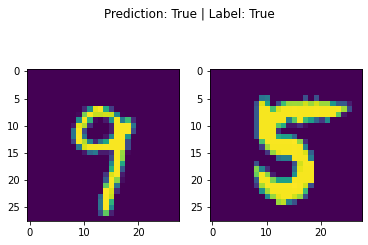

In [141]:
for img1, img2, label in test_dataset_greater.take(1):
    result = twinmodel_greater.predict((img1, img2))
    img1 = np.reshape(img1, (32, 28, 28))
    img2 = np.reshape(img2, (32, 28, 28))
    fig, ax = plt.subplots(1,2)
    fig.suptitle("Prediction: "+str(bool(np.around(result[0])))+" | Label: "+str(bool(np.asarray((label)[0]))))
    ax[0].imshow(img1[0])
    ax[1].imshow(img2[0])
    


**Sample prediction for subtract network**

1/1 [==============================] - 0s 19ms/step


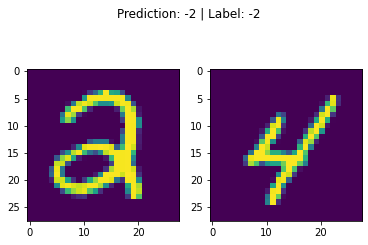

In [142]:
for img1, img2, label in test_dataset_subtract.take(1):
    result = twinmodel_subtract.predict((img1, img2))
    img1 = np.reshape(img1, (32, 28, 28))
    img2 = np.reshape(img2, (32, 28, 28))
    fig, ax = plt.subplots(1,2)
    fig.suptitle("Prediction: "+str(np.argmax(result[0])-9)+" | Label: "+str(np.argmax((label)[0])-9))
    ax[0].imshow(img1[0])
    ax[1].imshow(img2[0])
    